 # Notebook 2: Handling Imbalance with SMOTE and BalancedRandomForest + HPO

## 1. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

## 2. Load Data

In [2]:
train = pd.read_csv("imbtrain.csv", na_values=[], keep_default_na=False)
test = pd.read_csv("imbtest.csv", na_values=[], keep_default_na=False)

In [3]:
train.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,ME,66,510,No,No,0,118.0,133,20.06,248.1,99,21.09,214.4,122,9.65,5.3,5,1.43,1,False
1,AR,86,408,No,Yes,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0,False
2,KS,65,415,No,Yes,34,208.8,119,35.50,142.1,106,12.08,214.6,87,9.66,12.5,4,3.38,4,False
3,WV,95,415,No,No,0,175.2,91,29.78,244.4,109,20.77,75.8,95,3.41,7.5,2,2.03,1,False
4,TN,105,408,No,No,0,206.2,84,35.05,256.4,138,21.79,117.1,91,5.27,9.0,3,2.43,1,False


In [4]:
train['Churn'].value_counts()

False    2281
True       81
Name: Churn, dtype: int64

In [5]:
train['Churn'].value_counts(normalize=True)

False    0.965707
True     0.034293
Name: Churn, dtype: float64

In [6]:
test['Churn'].value_counts()

False    569
True      22
Name: Churn, dtype: int64

In [7]:
test['Churn'].value_counts(normalize=True)

False    0.962775
True     0.037225
Name: Churn, dtype: float64

## 3. Preprocessing

In [8]:
def preprocess(df):
    df = df.copy()
    df['Churn'] = df['Churn'].map({True: 1, False: 0})
    df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
    df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})
    df = df.drop(columns=['State'])  # Drop high cardinality feature for now
    return df

In [9]:
post_train = preprocess(train)
post_test = preprocess(test)

In [10]:
post_train.head(5)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,66,510,0,0,0,118.0,133,20.06,248.1,99,21.09,214.4,122,9.65,5.3,5,1.43,1,0
1,86,408,0,1,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0,0
2,65,415,0,1,34,208.8,119,35.50,142.1,106,12.08,214.6,87,9.66,12.5,4,3.38,4,0
3,95,415,0,0,0,175.2,91,29.78,244.4,109,20.77,75.8,95,3.41,7.5,2,2.03,1,0
4,105,408,0,0,0,206.2,84,35.05,256.4,138,21.79,117.1,91,5.27,9.0,3,2.43,1,0


In [11]:
X_train = post_train.drop('Churn', axis=1)
y_train = post_train['Churn']
X_test = post_test.drop('Churn', axis=1)
y_test = post_test['Churn']

In [12]:
X_train.head(5)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,66,510,0,0,0,118.0,133,20.06,248.1,99,21.09,214.4,122,9.65,5.3,5,1.43,1
1,86,408,0,1,16,145.7,88,24.77,191.0,129,16.24,215.5,82,9.70,11.3,7,3.05,0
2,65,415,0,1,34,208.8,119,35.50,142.1,106,12.08,214.6,87,9.66,12.5,4,3.38,4
3,95,415,0,0,0,175.2,91,29.78,244.4,109,20.77,75.8,95,3.41,7.5,2,2.03,1
4,105,408,0,0,0,206.2,84,35.05,256.4,138,21.79,117.1,91,5.27,9.0,3,2.43,1


In [13]:
y_train.head(5)

0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

#### Helper function for evaluation

In [14]:
from utils import evaluate_model

## 4. SMOTE + Regular Random Forest

In [15]:
from imblearn.over_sampling import SMOTE


--- SMOTE + Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.57      0.36      0.44        22

    accuracy                           0.97       591
   macro avg       0.77      0.68      0.71       591
weighted avg       0.96      0.97      0.96       591



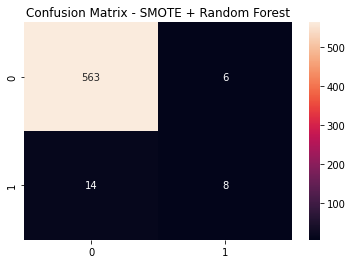

ROC-AUC: 0.907453267295095


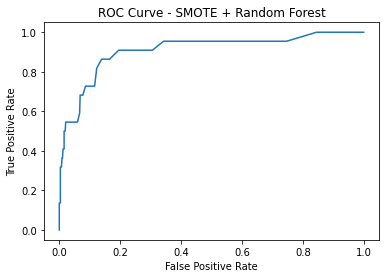

In [16]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_sm, y_sm)
evaluate_model(clf_smote, X_test, y_test, "SMOTE + Random Forest")

### 4.5. SMOTE + Regular Random Forest w/ HPO

In [17]:
from sklearn.model_selection import GridSearchCV


--- SMOTE + Random Forest (HPO) ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.60      0.41      0.49        22

    accuracy                           0.97       591
   macro avg       0.79      0.70      0.73       591
weighted avg       0.96      0.97      0.96       591



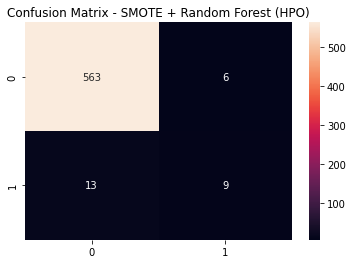

ROC-AUC: 0.9049768333599616


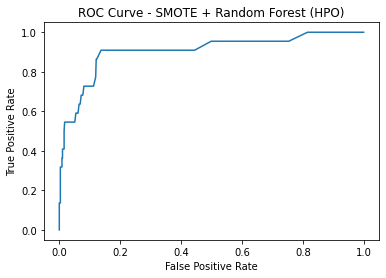

In [18]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

rf_params = {'n_estimators': [20, 50, 100, 150], 'max_depth': [None, 10, 20, 30]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='roc_auc', cv=4, n_jobs=-1)
gs_rf.fit(X_sm, y_sm)
evaluate_model(gs_rf.best_estimator_, X_test, y_test, "SMOTE + Random Forest (HPO)")

## 5. Balanced Random Forest (no SMOTE)

In [19]:
from imblearn.ensemble import BalancedRandomForestClassifier


--- Balanced Random Forest Only ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       569
           1       0.30      0.95      0.46        22

    accuracy                           0.92       591
   macro avg       0.65      0.94      0.71       591
weighted avg       0.97      0.92      0.94       591



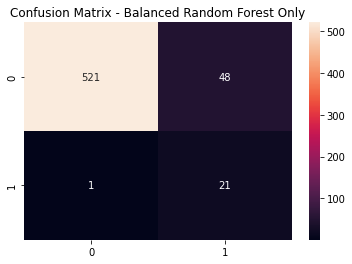

ROC-AUC: 0.9624540661447516


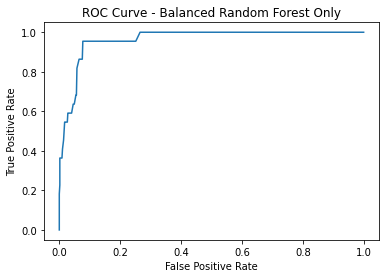

In [20]:
clf_balrf = BalancedRandomForestClassifier(random_state=42, n_estimators=100)
clf_balrf.fit(X_train, y_train)
evaluate_model(clf_balrf, X_test, y_test, "Balanced Random Forest Only")

### 5.5. Balanced Random Forest (no SMOTE) w/ HPO


--- Balanced Random Forest Only (HPO) ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       569
           1       0.28      0.91      0.43        22

    accuracy                           0.91       591
   macro avg       0.64      0.91      0.69       591
weighted avg       0.97      0.91      0.93       591



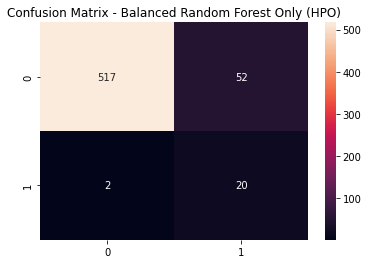

ROC-AUC: 0.9609362517974117


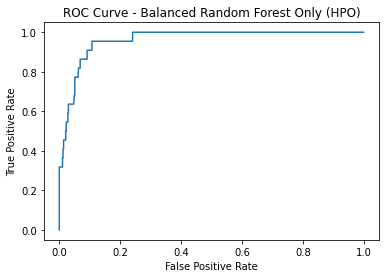

In [21]:
brf_params = {'n_estimators': [20, 50, 100, 150], 'max_depth': [None, 10, 20, 30]}
gs_brf = GridSearchCV(BalancedRandomForestClassifier(random_state=42), brf_params, scoring='roc_auc', cv=3, n_jobs=-1)
gs_brf.fit(X_train, y_train)
evaluate_model(gs_brf.best_estimator_, X_test, y_test, "Balanced Random Forest Only (HPO)")

## 6. SMOTE + Balanced Random Forest


--- SMOTE + Balanced Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.62      0.45      0.53        22

    accuracy                           0.97       591
   macro avg       0.80      0.72      0.76       591
weighted avg       0.97      0.97      0.97       591



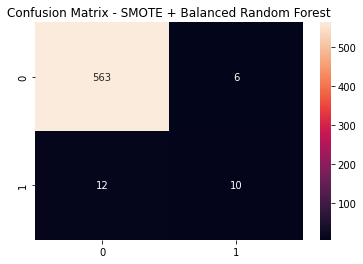

ROC-AUC: 0.9180779677264739


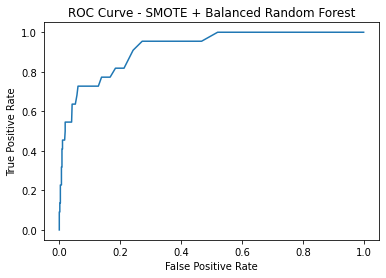

In [22]:
X_comb, y_comb = smote.fit_resample(X_train, y_train)
clf_comb = BalancedRandomForestClassifier(random_state=42, n_estimators=100)
clf_comb.fit(X_comb, y_comb)
evaluate_model(clf_comb, X_test, y_test, "SMOTE + Balanced Random Forest")

## 🔍 Why would someone combine SMOTE with a Balanced Random Forest?

1. They address imbalance in different ways
	•	SMOTE adds synthetic minority samples before training, altering the input data distribution.
	•	Balanced Random Forest (BRF) samples equal numbers of classes per tree during training, affecting the training process per estimator, but not the original dataset directly.

So together, they:
	•	Enrich the data (via SMOTE).
	•	Balance how it’s sampled internally (via BRF).

2. Theoretically, it can increase diversity + signal

SMOTE might inject useful minority-class structure that wouldn’t be seen in the original dataset.
Balanced Random Forest, meanwhile, ensures minority cases are not overwhelmed during the tree-building phase.

This might help stabilize the model if:
	•	The original minority class is too small for BRF to sample diverse enough trees.
	•	SMOTE alone creates too much synthetic noise without enough focus during learning.
⸻

🔴 But… often it’s redundant or counterproductive

Why?
	•	BRF already performs random undersampling + balancing internally. Adding SMOTE can just inject synthetic noise without improving generalization.
	•	You risk overfitting to synthetic patterns from SMOTE that don’t generalize well — especially since BRF will aggressively focus on these new samples.
	•	Computationally inefficient: you’re adding preprocessing and larger training sets for marginal gain.

⸻

✅ When to consider combining them:
	•	The original minority class is very small or noisy, and BRF performs poorly alone.
	•	You need to inject known structure via SMOTE before training.
	•	You’re conducting model exploration or ensembling multiple views of the data.

⸻

💡 TL;DR

Don’t assume more balancing = better results. BRF already handles imbalance. Try both separately first. Combine only if you find they add value together in validation results.